In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# data: pd.DataFrame = pd.read_csv("data/StudentPerformanceFactors.csv") # type: ignore
data = pd.read_parquet("../data/output_finalDf/")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5915 entries, 0 to 5914
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Hours_Studied      5915 non-null   int32
 1   Attendance         5915 non-null   int32
 2   Sleep_Hours        5915 non-null   int32
 3   Previous_Scores    5915 non-null   int32
 4   Tutoring_Sessions  5915 non-null   int32
 5   Physical_Activity  5915 non-null   int32
 6   Exam_Score         5915 non-null   int32
dtypes: int32(7)
memory usage: 161.9 KB


In [3]:
print(data.shape)
data.describe()

(5915, 7)


,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,5915.000000,5915.000000,5915.000000,5915.000000,5915.000000,5915.000000,5915.000000
mean,19.991040,79.985461,7.040406,75.080473,1.289265,2.962975,67.144379
std,5.822776,11.534313,1.468722,14.362626,0.982435,1.029074,3.844076
min,4.000000,60.000000,4.000000,50.000000,0.000000,0.000000,56.000000
25%,16.000000,70.000000,6.000000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.000000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.000000,88.000000,2.000000,4.000000,69.000000
max,36.000000,100.000000,10.000000,100.000000,3.000000,6.000000,100.000000


array([[<Axes: title={'center': 'Hours_Studied'}>,
        <Axes: title={'center': 'Attendance'}>,
        <Axes: title={'center': 'Sleep_Hours'}>],
       [<Axes: title={'center': 'Previous_Scores'}>,
        <Axes: title={'center': 'Tutoring_Sessions'}>,
        <Axes: title={'center': 'Physical_Activity'}>],
       [<Axes: title={'center': 'Exam_Score'}>, <Axes: >, <Axes: >]],
      dtype=object)

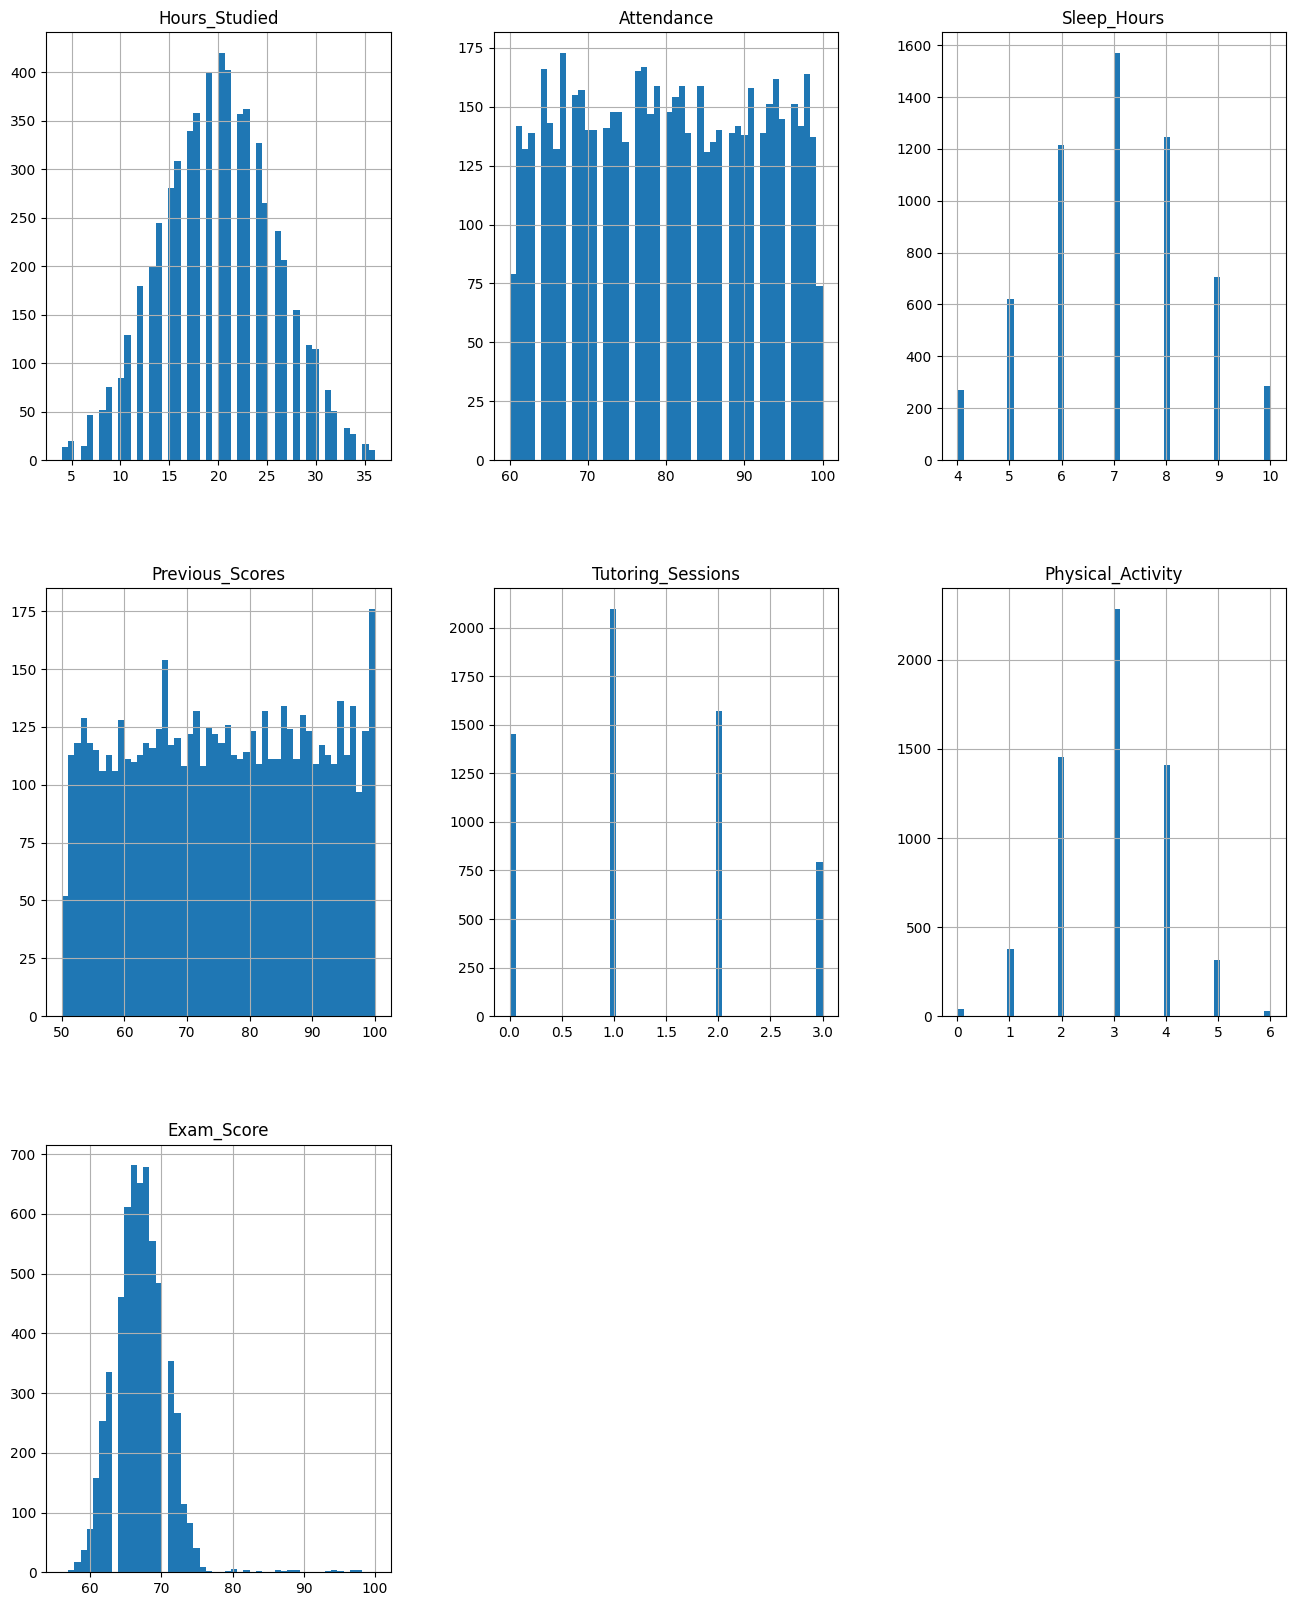

In [4]:
data.hist(figsize=(16,20), bins=50)

<Axes: >

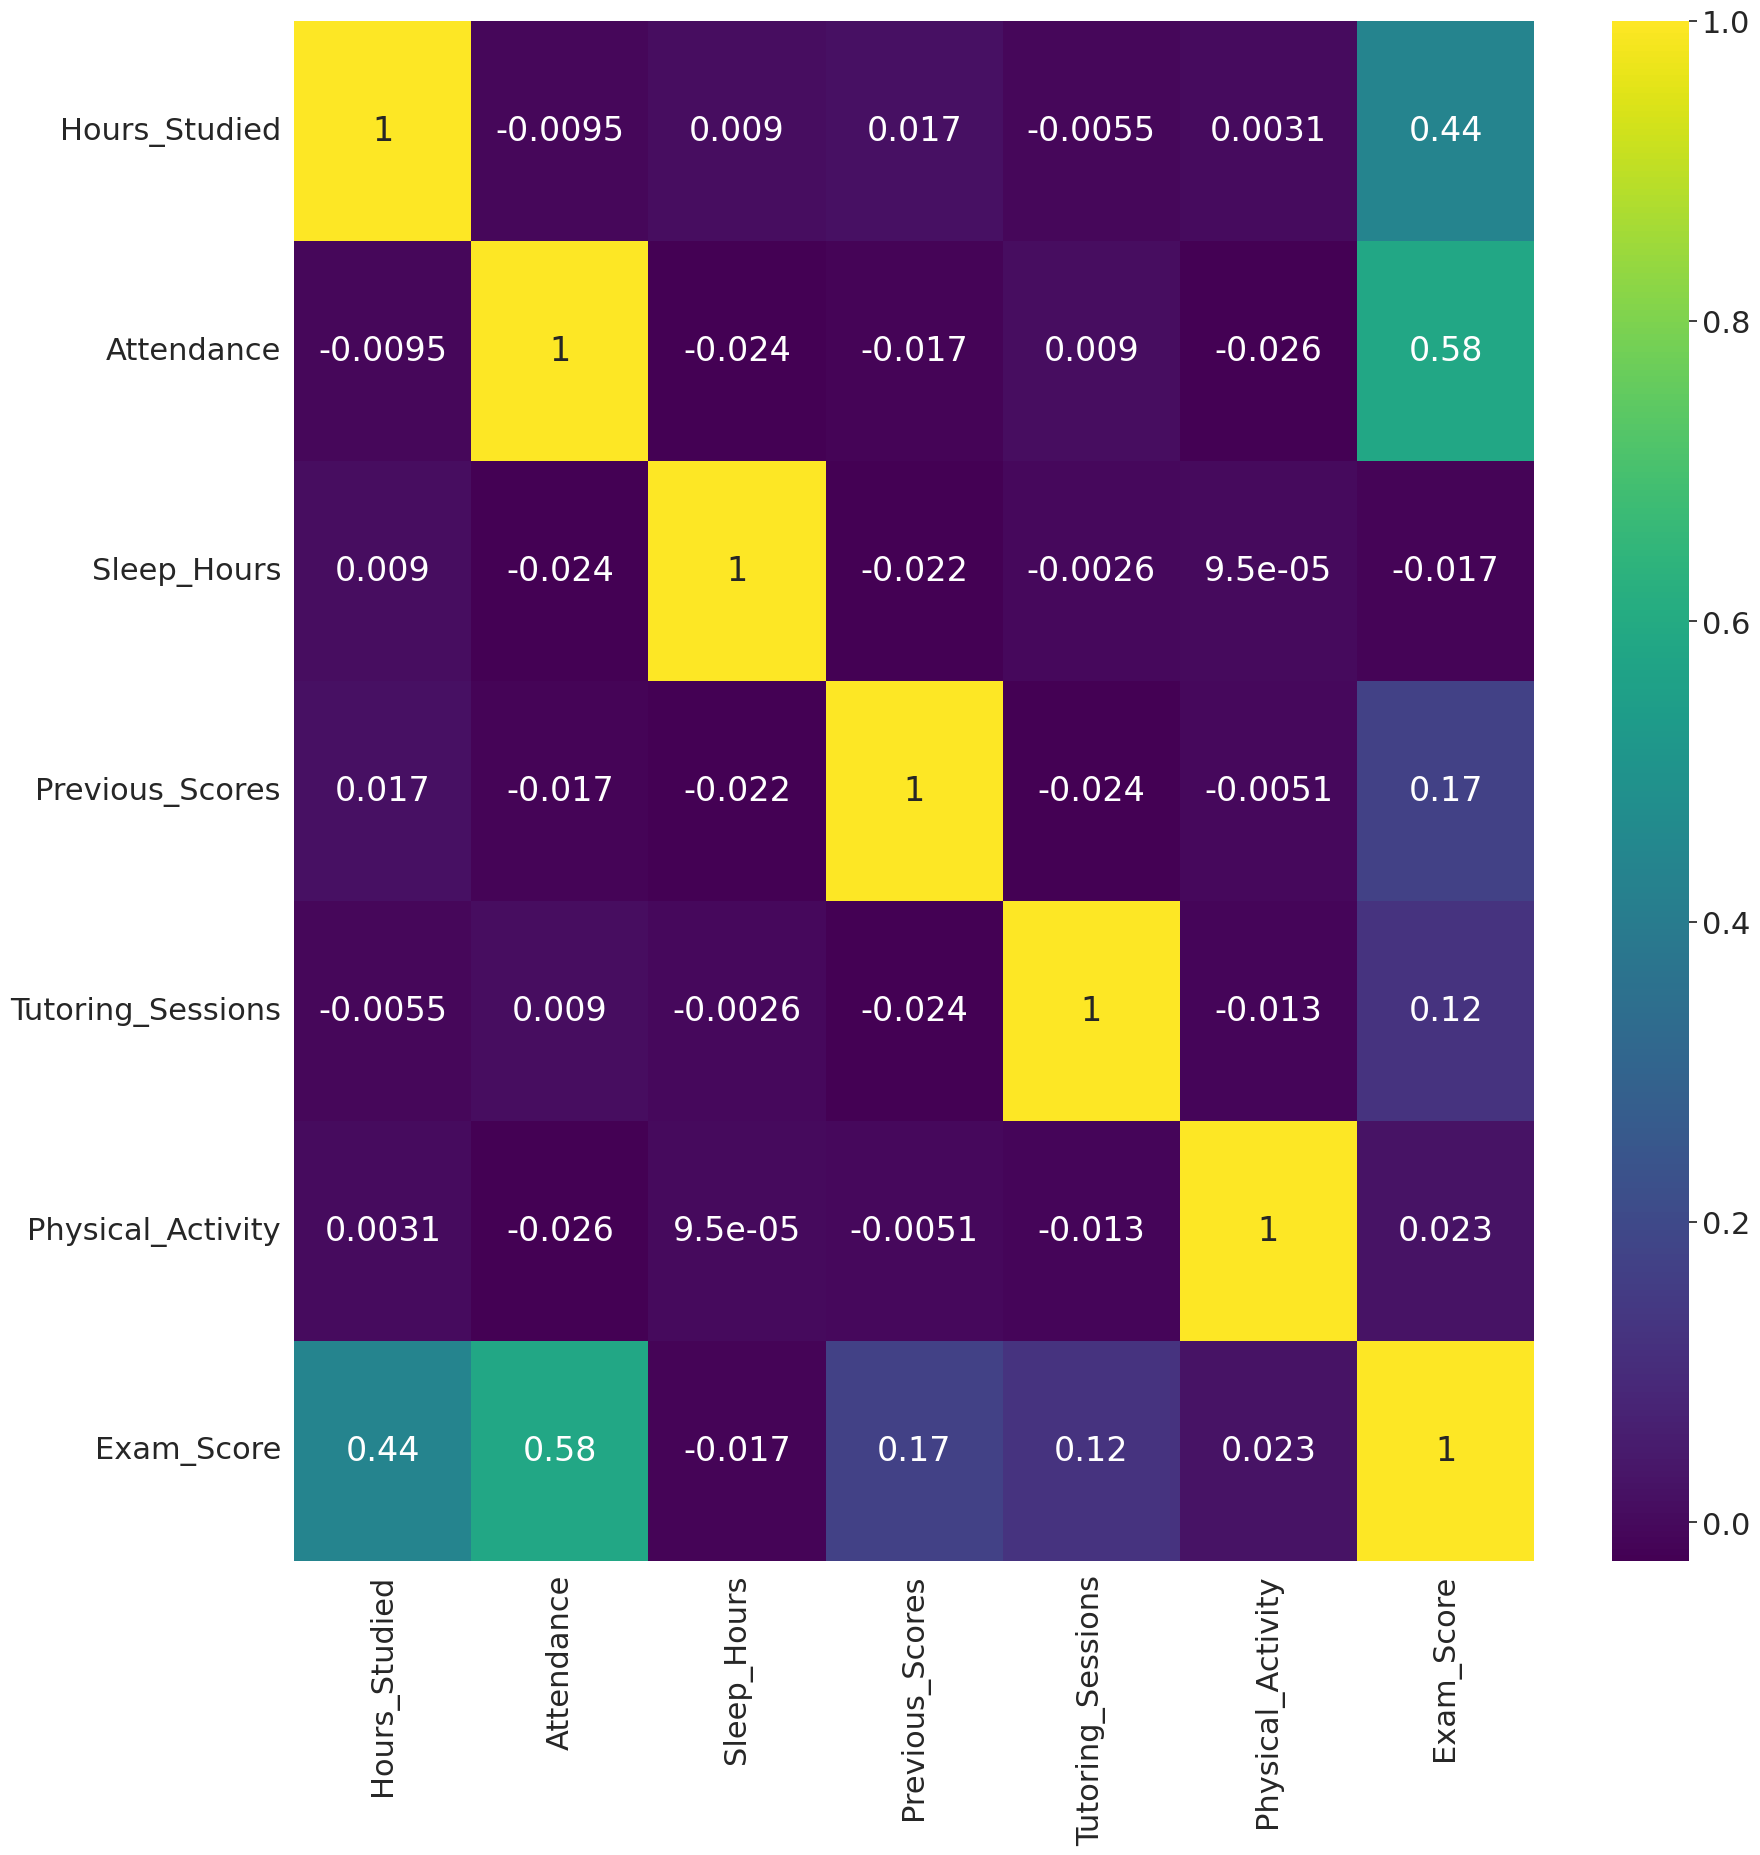

In [5]:
corr = data [['Hours_Studied',
'Attendance',
# 'Parental_Involvement',
# 'Access_to_Resources',
# 'Extracurricular_Activities',
'Sleep_Hours',
'Previous_Scores',
# 'Motivation_Level',
# 'Internet_Access',
'Tutoring_Sessions',
# 'Family_Income',
# 'Teacher_Quality',
# 'School_Type',
# 'Peer_Influence',
'Physical_Activity',
# 'Learning_Disabilities',
# 'Parental_Education_Level',
# 'Distance_from_Home',
# 'Gender',
'Exam_Score']].corr()
plt.figure(figsize=(20,20))
sns.set(style="darkgrid", font_scale=2)
plt.xlabel("",fontsize=20)
plt.ylabel("",fontsize=20)

sns.heatmap(corr, cmap="viridis", annot=True)

In [6]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(20,10))
# sns.histplot(data['Distance_from_Home'], bins=10, kde=True)

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

In [7]:
mean_grade = (
    data
    .groupby(["Parental_Involvement", "Access_to_Resources"], observed=True)   # observed=True = pas de combinaisons vides
    ["Exam_Score"]
    .mean()
    .reset_index()
)

mean_grade.head()
pivot = mean_grade.pivot(
    index="Parental_Involvement",
    columns="Access_to_Resources",
    values="Exam_Score"
)

pivot

KeyError: 'Parental_Involvement'

<Axes: xlabel='Access_to_Resources', ylabel='Parental_Involvement'>

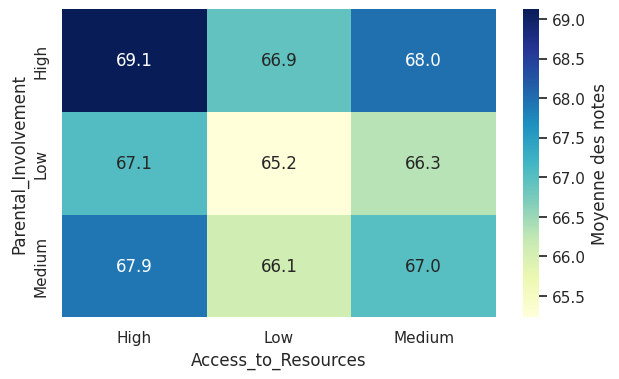

In [ ]:
plt.figure(figsize=(7,4))
sns.heatmap(
    pivot,
    annot=True, fmt=".1f",
    cmap="YlGnBu",
    cbar_kws={"label": "Moyenne des notes"}
)

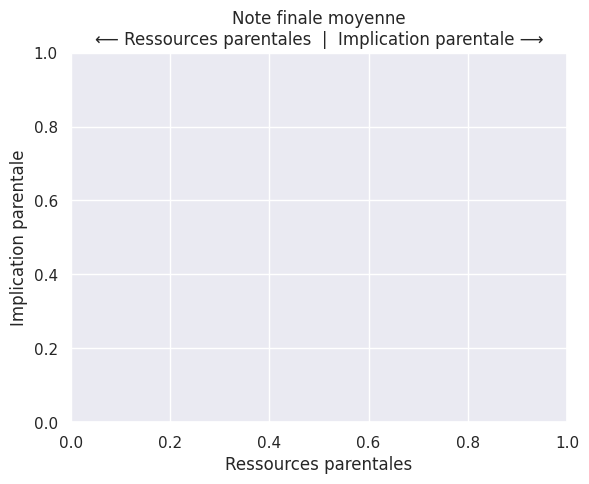

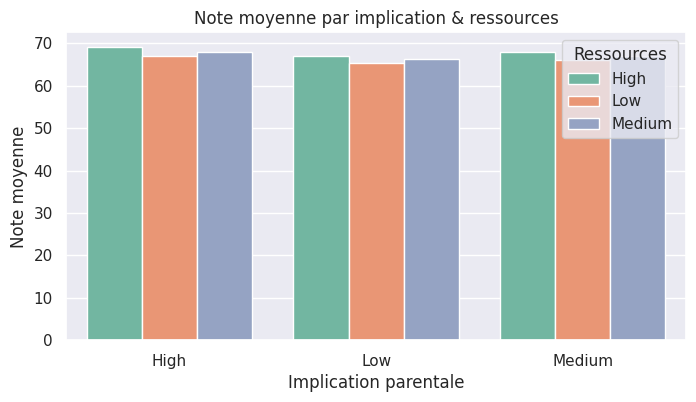

In [ ]:
plt.title("Note finale moyenne\n⟵ Ressources parentales  |  Implication parentale ⟶")
plt.ylabel("Implication parentale")
plt.xlabel("Ressources parentales")
plt.show()
plt.figure(figsize=(8,4))
sns.barplot(
    data=mean_grade,
    x="Parental_Involvement",
    y="Exam_Score",
    hue="Access_to_Resources",
    palette="Set2"
)
plt.title("Note moyenne par implication & ressources")
plt.ylabel("Note moyenne")
plt.xlabel("Implication parentale")
plt.legend(title="Ressources")
plt.show()